## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Phase 2. Beyond Fast Track
Goal of Phase 2 is to get a final model addressing all issues and inaccuracies encountered during Phase 1(Fast Track)

## Fast Track Conclusions
R squared = 66%. The linear model explains 66% of the variations in the house price. 
The model tends to under predict (predicted value < actual value), especially on the high end of the price range 
Training and test performances seem close based on visualization, but Mean Square Error (MSE) for test is 22% higher than for the training set. 
Presence of outliers is evidenced by the prediction errors visualization. They are likely to be responsible for a good part of the inaccuracy of the model. Needs to be addressed in forthcoming work.

## Workflow:
1. address non-numerical data
2. Address the issue due to the presence of outliers  
3. Address potential collinearity between features  
4. Features selection step 1 
5. Address the issue of missing values  
6. Address categorical data  
7. Features selection step 2  
8. Features transformation and scaling  
9. test/train split. Regression.
10. QC and Check assumptions: Linearity/ Model Residuals are normally distrib/ Homoscedasticity


## Importing needed modules, libraries ...

In [1998]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns

import scipy.stats as stats

## Data import

In [1893]:
dfull = pd.read_csv('kc_house_data.csv')
df=dfull.copy()

In [1894]:
# how many data points(rows)? How many variables (columns)?
df.shape

(21597, 21)

# Looking for duplicated entries

In [1895]:
#Flag duplicates with True (if any)
df.duplicated().value_counts()

False    21597
dtype: int64

In [1896]:
#No duplicates in the data

## Reminder  
Target variable (i.e. independent variable) = 'price'  
21597 raw data points
20 potential descriptors

# 1. Looking for non-numerical data 

In [1897]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [1898]:
# columns 'date' and 'sqft_basement' are non numerical
# what is the data type of sqft_basement?
type(df['sqft_basement'][0])

str

In [1899]:
# checking unique values of column sqft_basement
np.sort(df['sqft_basement'].unique())

array(['0.0', '10.0', '100.0', '1000.0', '1008.0', '1010.0', '1020.0',
       '1024.0', '1030.0', '1040.0', '1050.0', '1060.0', '1070.0',
       '1080.0', '1090.0', '110.0', '1100.0', '1110.0', '1120.0',
       '1130.0', '1135.0', '1140.0', '1150.0', '1160.0', '1170.0',
       '1180.0', '1190.0', '120.0', '1200.0', '1210.0', '1220.0',
       '1230.0', '1240.0', '1245.0', '1248.0', '1250.0', '1260.0',
       '1270.0', '1275.0', '1280.0', '1281.0', '1284.0', '1290.0',
       '130.0', '1300.0', '1310.0', '1320.0', '1330.0', '1340.0',
       '1350.0', '1360.0', '1370.0', '1380.0', '1390.0', '140.0',
       '1400.0', '1410.0', '1420.0', '143.0', '1430.0', '1440.0', '145.0',
       '1450.0', '1460.0', '1470.0', '1480.0', '1481.0', '1490.0',
       '150.0', '1500.0', '1510.0', '1520.0', '1525.0', '1530.0',
       '1540.0', '1548.0', '1550.0', '1560.0', '1570.0', '1580.0',
       '1590.0', '160.0', '1600.0', '1610.0', '1620.0', '1630.0',
       '1640.0', '1650.0', '1660.0', '1670.0', '1680.0',

In [1900]:
# column sqft_basement has multiple question marks instead of values!!
# check number of records with ? as sqft_basement
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2120.0        1
1990.0        1
475.0         1
176.0         1
556.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [1901]:
# How many '?' in sqft_basement column? in %
print( "% of '?' in column sqft_basement : ",100* len(df[df['sqft_basement']=='?'])/len(df) ) 
print( "# of '?' in column sqft_basement : ", len(df[df['sqft_basement']=='?']) )

% of '?' in column sqft_basement :  2.1021438162707784
# of '?' in column sqft_basement :  454


### Rationale: 
#### According to definitions of variables we should have:
#### sqft_basement = sqft_living -sqft_above

In [1902]:
# let's check sqft_basement = sqft_living -sqft_above
# select only rows without ? in sqft_basement
# copy of df to avoid chained indexing warning
df2=df.loc[ df['sqft_basement'] != '?' ].copy()
# change type of sqft_basement to float64
df2['sqft_basement']=df2['sqft_basement'].astype('float64')

# compute sqft_basement according to formula and compare to given sqft_basement
df2['sqft_basement2'] =  df2['sqft_living'] -df2['sqft_above']
df2['sqft_bas_diff'] = df2['sqft_basement2'] - df2['sqft_basement']

df2['sqft_bas_diff'].describe()

count    21143.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: sqft_bas_diff, dtype: float64

In [1903]:
# Ok at this point we could  replace '?' by the calculated value  sqft_living -sqft_above
print('check before: ',df['sqft_basement'].iloc[18])
df.loc[df['sqft_basement'] == '?',['sqft_basement']] = df['sqft_living']-df['sqft_above']
print('check after: ',df['sqft_basement'].iloc[18])


check before:  ?
check after:  0


In [1904]:
# check
print( "# of '?' in column sqft_basement : ", len(df[df['sqft_basement']=='?']) )

# of '?' in column sqft_basement :  0


### Rationale: 
At this point we could  replace '?' in sqft_basement  by the calculated value  sqft_living -sqft_above
But, we would get 3 variables such as each one can be derived from the other 2. This is a situation of perfect multicollinearity similar to the dummy variable trap.
The right thing to do is to drop one f the 3 variables.


In [1905]:
# we drop sqft_basement
df = df.drop(['sqft_basement'],axis = 1)

In [1906]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [1907]:
# check date column. type?
print(df.date[0])
type(df.date[0])


10/13/2014


str

In [1908]:
# change date type to datetime
# then, keep only the year from 'date' (date it was sold) and make it an integer
df['date']=pd.to_datetime(df['date']).dt.year.astype('int')


In [1909]:
# checking  date now
df['date'][0:5]

0    2014
1    2014
2    2015
3    2014
4    2015
Name: date, dtype: int32

## Looking for NaN values


In [1910]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
id               21597 non-null int64
date             21597 non-null int32
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int32(1), int64(11)
memory usage: 3.2 MB


### NaN values issues with waterfront, view, yr_renovated

In [1911]:
# Let's check waterfront
print( 'values in waterfront : ', df['waterfront'].unique() )
print(  '% of NaN in waterfront : ', 100*(len(df) - np.sum(df['waterfront'].value_counts()))  / len(df) )
print( '% of 0 in waterfront : ', 100*(np.sum(df['waterfront'].value_counts()[0]))  / len(df) )
print( '% of 1 in waterfront : ',100*(np.sum(df['waterfront'].value_counts()[1]))  / len(df) )

values in waterfront :  [nan  0.  1.]
% of NaN in waterfront :  11.00152798999861
% of 0 in waterfront :  88.32245219243413
% of 1 in waterfront :  0.6760198175672547


In [1912]:
# 11 % of the values in waterfront are Nan
# as the majority of houses are not waterfrnt( 88% of zeroes), we will replace NaN with zero
df['waterfront'] = df['waterfront'].fillna(0)

In [1913]:
# Let's check waterfront again
print( 'values in waterfront : ', df['waterfront'].unique() )
print(  '% of NaN in waterfront : ', 100*(len(df) - np.sum(df['waterfront'].value_counts()))  / len(df) )
print( '% of 0 in waterfront : ', 100*(np.sum(df['waterfront'].value_counts()[0]))  / len(df) )
print( '% of 1 in waterfront : ',100*(np.sum(df['waterfront'].value_counts()[1]))  / len(df) )

values in waterfront :  [0. 1.]
% of NaN in waterfront :  0.0
% of 0 in waterfront :  99.32398018243275
% of 1 in waterfront :  0.6760198175672547


In [1914]:
# Let's check view
print( 'values in view : ', df['view'].unique() )


values in view :  [ 0. nan  3.  4.  2.  1.]


In [1915]:
# 'view' is supposed to mean whether the data has been viewed. 
# This does not make sense to me  as the data stops in 2015 
# So we drop this feature 'view'

In [1916]:
# check most recent year for house sold:
df['date'].max()

2015

In [1917]:
# drop column 'view'
df.drop('view',axis =1, inplace = True)

In [1918]:
# check # of columns was reduced to 20
df.shape

(21597, 19)

In [1919]:
# check yr_renovated
# print all distinct values
print( 'values in yr_renovated : ', df['yr_renovated'].unique() )
print(  'occurences for each distinct value in yr_renovated : ', df['yr_renovated'].value_counts() )
print(  '% of 0 in yr_renovated: ' , 100* np.sum(df['yr_renovated'].value_counts()[0]) / len(df) )
print(  '% of NaN in yr_renovated: ' , 100* (len(df)  - np.sum(df['yr_renovated'].value_counts()) ) / len(df) )

values in yr_renovated :  [   0. 1991.   nan 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984.
 1954. 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999.
 1998. 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 2001. 1980. 1971.
 1979. 1997. 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963.
 1951. 1962. 1953. 1993. 1996. 1955. 1982. 1956. 1940. 1976. 1946. 1975.
 1964. 1973. 1957. 1959. 1960. 1967. 1965. 1934. 1972. 1944. 1958.]
occurences for each distinct value in yr_renovated :  0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64
% of 0 in yr_renovated:  78.7655692920313
% of NaN in yr_renovated:  17.78950780200954


In [1920]:
# As there is a majority of yr_renovated = 0 (79%) and 18% of the values are NaN, 
# we will replace NaN by the mode: 0
df['yr_renovated'].fillna(value =0,inplace = True)

In [1921]:
# check 
print( 'values in yr_renovated : ', df['yr_renovated'].unique() )

print(  '% of 0 in yr_renovated: ' , 100* np.sum(df['yr_renovated'].value_counts()[0]) / len(df) )
print(  '% of NaN in yr_renovated: ' , 100* (len(df)  - np.sum(df['yr_renovated'].value_counts()) ) / len(df) )

values in yr_renovated :  [   0. 1991. 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984. 1954.
 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999. 1998.
 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 2001. 1980. 1971. 1979.
 1997. 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963. 1951.
 1962. 1953. 1993. 1996. 1955. 1982. 1956. 1940. 1976. 1946. 1975. 1964.
 1973. 1957. 1959. 1960. 1967. 1965. 1934. 1972. 1944. 1958.]
% of 0 in yr_renovated:  96.55507709404084
% of NaN in yr_renovated:  0.0


In [1922]:
# for yr_renovated, 0 doesn't make sense.
# We will replace 0 by the year the house was built. 
# This will enable yr_renovated to be used as a predictor
df['yr_renovated'] = df[['yr_renovated','yr_built']].max(axis=1)

In [1923]:
# check
df['yr_renovated'].value_counts()

2014.0    632
2005.0    479
2006.0    473
2004.0    455
2003.0    450
         ... 
1901.0     28
1902.0     26
1933.0     24
1935.0     20
1934.0     15
Name: yr_renovated, Length: 116, dtype: int64

### We created inadvertently a heavy correlation between yr_correlated and yr_built. 
### We will only keep the predictor that has the highest correlation to price.
### Check correlation:

In [1924]:
df_check = df[['yr_renovated','yr_built','price']]
df_check.corr()

,yr_renovated,yr_built,price
yr_renovated,1.000000,0.926406,0.097541
yr_built,0.926406,1.000000,0.053953
price,0.097541,0.053953,1.000000


### The correlation of price with yr_renovated is much bigger (9.7%) as the correlation between price and yr_built (5.4%). Therefore we keep only yr_renovated and remove yr_built.
### Note: the absolute values of these correlations are quite small. So this feature may end up being discarded later in the process anyway 

In [1925]:
# remove yr_built column
df=df.drop('yr_built',axis = 1)

In [1926]:
# check we don't have any NaN values left
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 18 columns):
id               21597 non-null int64
date             21597 non-null int32
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(7), int32(1), int64(10)
memory usage: 2.9 MB


In [1927]:
# copy of data without NaN
dfnum=df.copy()

# 1. Looking for non-numerical data    - done
# 2. Detect and Address Outliers

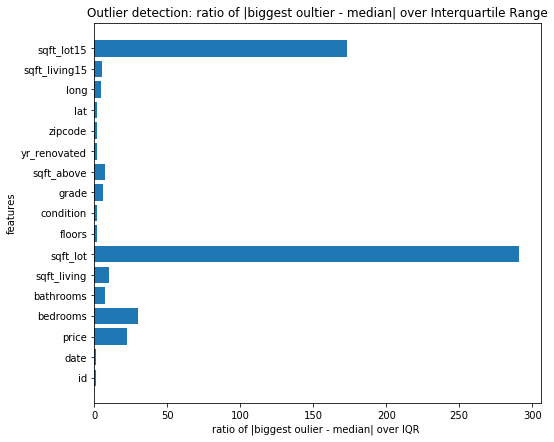

In [1928]:
# detect ouliers using InterQuartile Range (IQR) 
dico={}
for col in df.columns:
    if df[col].quantile(.75) - df[col].quantile(.25)  != 0:
#         For features with IQR > 0, calculate the distance of the biggest outlier to the median 
        maxi=max(df[col].max() - df[col].median() ,  df[col].median() -df[col].min() )
#     divide by IQR 
        dico[col] = maxi  /  (df[col].quantile(.75) - df[col].quantile(.25))
# visualization of the ratio with a bar plot
plt.figure(figsize = (8,7))
plt.barh( list(dico.keys()) ,list(dico.values())  )
plt.xlabel('ratio of |biggest oulier - median| over IQR ')
plt.ylabel('features')
plt.title('Outlier detection: ratio of |biggest oultier - median| over Interquartile Range')
plt.show();

#### sqft_lot and sqft_lot15 have the "biggest" outliers. Let's check them first:

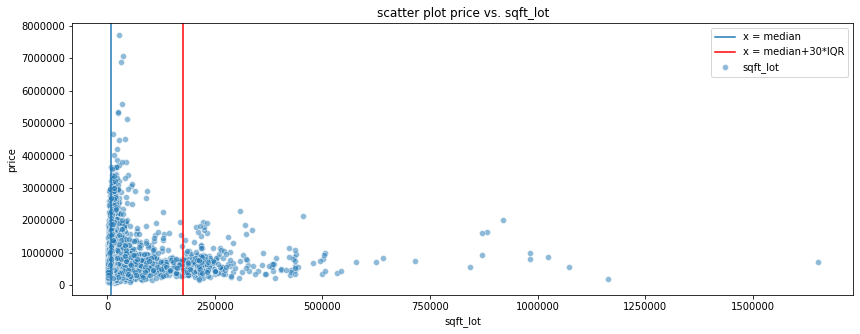

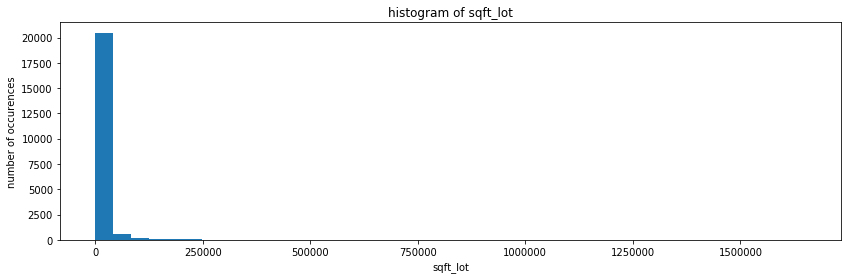

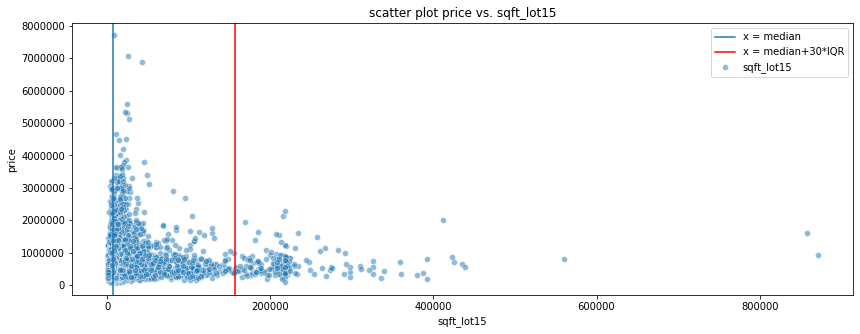

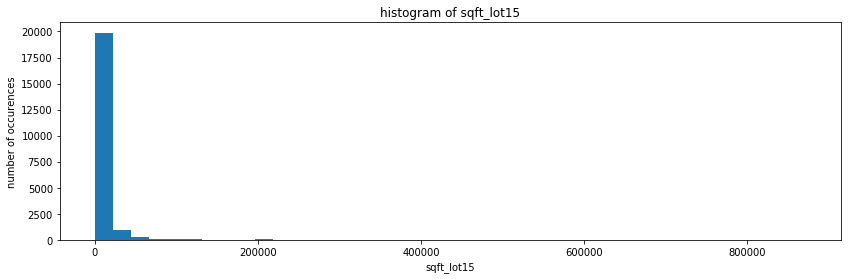

In [1929]:
# Visualization of sqft_lot and sqft_lot15 vs the target variable price
df_plot = df[['price','sqft_lot','sqft_lot15']]

for feat in ['sqft_lot','sqft_lot15']:
    plt.figure(figsize=(14,5))
    sns.scatterplot(x=feat, y='price',data=df_plot,alpha=0.5,label = feat)
    plt.axvline(x=df_plot[feat].median(), label = 'x = median')
    IQR = df[feat].quantile(.75) - df[feat].quantile(.25)
    plt.axvline(x=df_plot[feat].median() + 30*IQR, label = 'x = median+30*IQR',color = 'r')
    plt.title('scatter plot price vs. {}'.format(feat))
    plt.legend()
    plt.show();  
    plt.figure(figsize=(14,4))
    plt.hist(df[feat],bins=40)
    plt.title('histogram of {}'.format(feat))
    plt.xlabel(feat)
    plt.ylabel('number of occurences')
    plt.show();

In [1930]:
# check correlations
df_plot.corr()

,price,sqft_lot,sqft_lot15
price,1.000000,0.089876,0.082845
sqft_lot,0.089876,1.000000,0.718204
sqft_lot15,0.082845,0.718204,1.000000


In [1931]:
print('shape before: ',df.shape)
df=df.loc[(df['sqft_lot'] < 200000) & (df['sqft_lot15']<200000)]
print('shape after: ',df.shape)

shape before:  (21597, 18)
shape after:  (21294, 18)


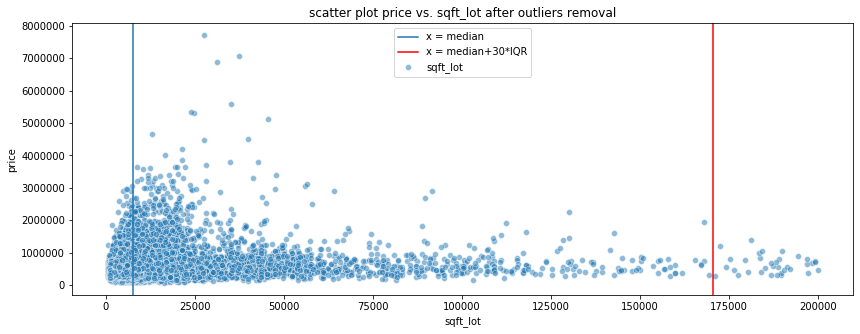

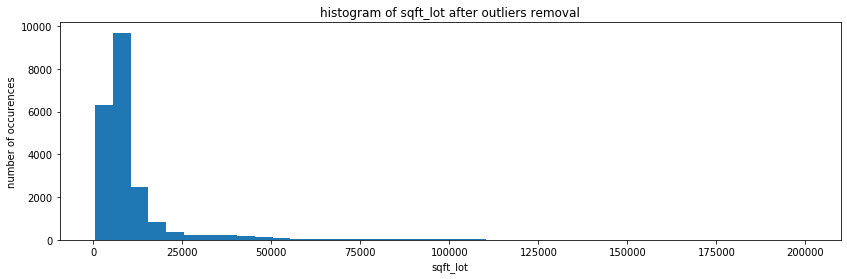

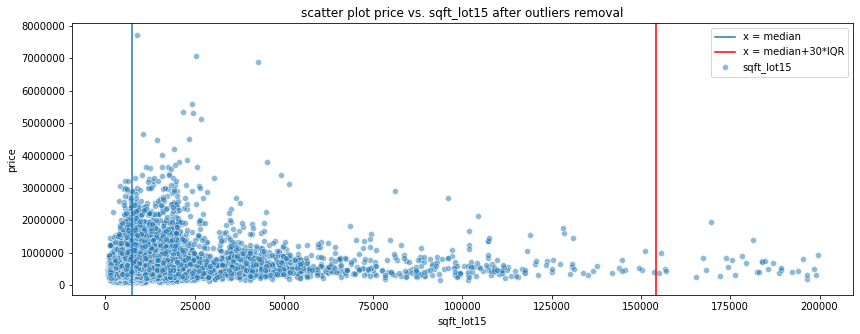

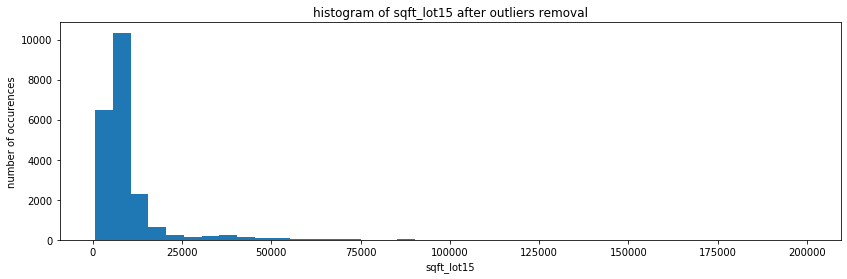

In [1932]:
# QC after outliers removal
# Visualization of sqft_lot and sqft_lot15 vs the target variable price
df_plot = df[['price','sqft_lot','sqft_lot15']]

for feat in ['sqft_lot','sqft_lot15']:
    plt.figure(figsize=(14,5))
    sns.scatterplot(x=feat, y='price',data=df_plot,alpha=0.5,label = feat)
    plt.axvline(x=df_plot[feat].median(), label = 'x = median')
    IQR = df[feat].quantile(.75) - df[feat].quantile(.25)
    plt.axvline(x=df_plot[feat].median() + 30*IQR, label = 'x = median+30*IQR',color = 'r')
    plt.title('scatter plot price vs. {} after outliers removal'.format(feat))
    plt.legend()
    plt.show();  
    plt.figure(figsize=(14,4))
    plt.hist(df[feat],bins=40)
    plt.title('histogram of {} after outliers removal'.format(feat))
    plt.xlabel(feat)
    plt.ylabel('number of occurences')
    plt.show();

In [1933]:
# check correlations
df_plot.corr()

,price,sqft_lot,sqft_lot15
price,1.000000,0.121352,0.109718
sqft_lot,0.121352,1.000000,0.783790
sqft_lot15,0.109718,0.783790,1.000000


## Conclusion for features sqft_lot and sqft_lot15
#### Very strong correlation between sqft_lot and sqft_lot15. 
#### Small correlation between sqft_lot(15) and target variable price
#### These  correlations have increased when we removed outliers. We can expect a better model without these outliers.
#### , Visually, no clear linear relationship between sqft_lot(15) and target variable price  
  
#### To avoid collinearity problems, we will replace sqft_lot15 by a ratio between sqft_lot and sqft_lot_15.
#### If the ratio is close to 1, it means that the house is in a neighborhood with similar lot size.
#### If the ratio is <<1, the lot is smaller than the neighbors, and it could predict a lower price than a similar lot size in a neighborhood with bigger lot sizes
#### If the ratio is >>1 the lot is bigger than the neighbors, and it could predict a higher price than a similar lot size in a neighborhood with smaller lot sizes


In [1934]:
# To avoid collinearity problems, we will replace sqft_lot15 by a ratio between sqft_lot and sqft_lot_15.
df['sqft_lot15'] = df['sqft_lot']/df['sqft_lot15']

In [1935]:
df.rename(columns={'sqft_lot15': 'sqft_lot_ratio15'},inplace = True)

In [1936]:
# check:
df['sqft_lot_ratio15'].describe()

count    21294.000000
mean         1.097087
std          0.800990
min          0.054972
25%          0.936525
50%          1.000000
75%          1.088430
max         44.389138
Name: sqft_lot_ratio15, dtype: float64

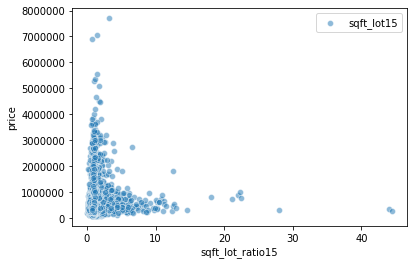

In [1937]:
# check:
sns.scatterplot(x='sqft_lot_ratio15', y='price',data=df,alpha=0.5,label = feat)

In [1938]:
# remove outliers 
print('shape before: ',df.shape)
df=df.loc[(df['sqft_lot_ratio15'] < 20)]
print('shape after: ',df.shape)

shape before:  (21294, 18)
shape after:  (21287, 18)


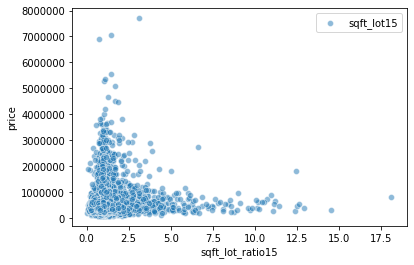

In [1939]:
# check:
sns.scatterplot(x='sqft_lot_ratio15', y='price',data=df,alpha=0.5,label = feat)

In [1940]:
dftemp=df[['sqft_lot_ratio15','price']]
dftemp.corr()

,sqft_lot_ratio15,price
sqft_lot_ratio15,1.000000,0.045732
price,0.045732,1.000000


## Back to the outliers:
### Let's look at the target

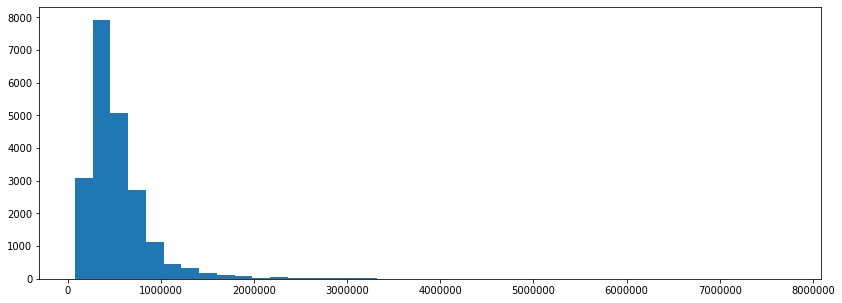

count    2.128700e+04
mean     5.384219e+05
std      3.670614e+05
min      7.800000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.400000e+05
max      7.700000e+06
Name: price, dtype: float64

In [1941]:
# histogram and Measure of central tendency
plt.figure(figsize=(14,5))
plt.hist(df['price'],bins=40)
plt.show();
df['price'].describe()

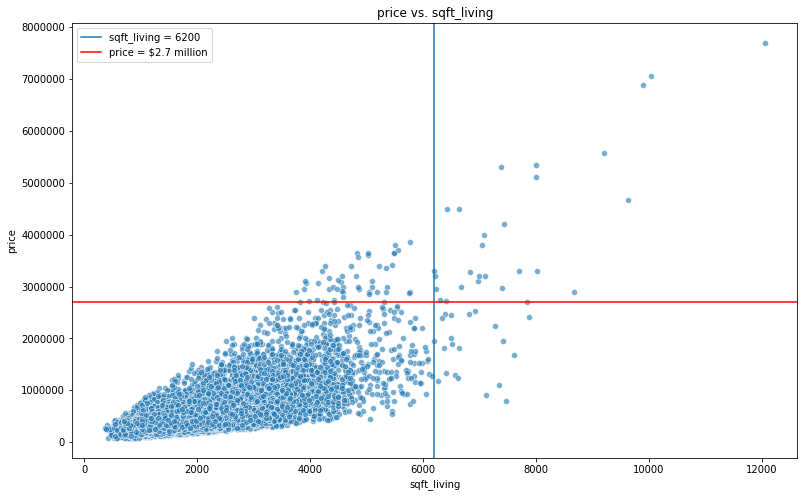

In [1942]:
# scatterplot of price vs. sqft_living.
# Whysqft_living? Because sqft_living is the best correlation with price (identified so far)
df_plot2=df[['price','sqft_living']]
plt.figure(figsize=(13,8))
sns.scatterplot(x='sqft_living', y='price',data=df_plot2,alpha=0.6)
plt.axvline(x=6200, label=('sqft_living = 6200'))
plt.axhline(y=2700000, label=('price = $2.7 million'),color = 'r')
plt.title('price vs. sqft_living')
plt.legend()
plt.show();

## Rationale:
### The range of the prices goes very high, but we have very few data points over  2.7 million dollars. 
### When we plot price vs sqft_living as a  scatterplot, the cloud of points gets very scattered for sqft_living above above 6200 sqft
### From a business point of view, it could be nice to have a good model for very expensive houses to be on the high end of the market, but the scarcity of the data points makes this a difficult task. We will therefore focus on the low to mid range of the market, that we define by sqft_living < 6200 and price <3.5 million dollars.
### To get a reliable model past these thresholds, we would need more data.

In [1943]:
print('shape before: ',df.shape)
df=df.loc[(df['sqft_living'] < 6200) & (df['price']<2700000)]
print('shape after: ',df.shape)

shape before:  (21287, 18)
shape after:  (21188, 18)


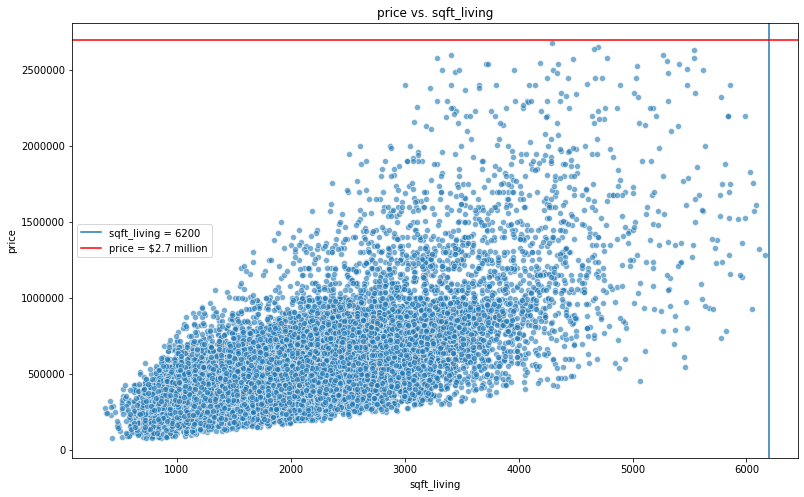

In [1944]:
# checking ...
df_plot2=df[['price','sqft_living']]
plt.figure(figsize=(13,8))
sns.scatterplot(x='sqft_living', y='price',data=df_plot2,alpha=0.6)
plt.axvline(x=6200, label=('sqft_living = 6200'))
plt.axhline(y=2700000, label=('price = $2.7 million'),color = 'r')
plt.title('price vs. sqft_living')
plt.legend()
plt.show();

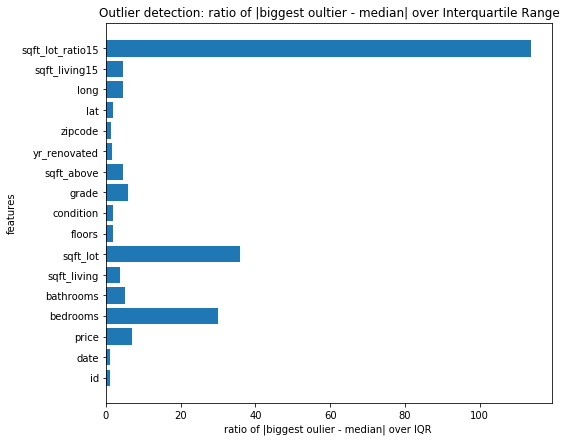

In [1945]:
# Let's look at the same bar plot as before to detect ouliers using our latest updated data
# detect ouliers using InterQuartile Range (IQR) 
dico={}
for col in df.columns:
    if df[col].quantile(.75) - df[col].quantile(.25)  != 0:
#         For features with IQR > 0, calculate the distance of the biggest outlier to the median 
        maxi=max(df[col].max() - df[col].median() ,  df[col].median() -df[col].min() )
#     divide by IQR 
        dico[col] = maxi  /  (df[col].quantile(.75) - df[col].quantile(.25))
# visualization of the ratio with a bar plot
plt.figure(figsize = (8,7))
plt.barh( list(dico.keys()) ,list(dico.values())  )
plt.xlabel('ratio of |biggest oulier - median| over IQR ')
plt.ylabel('features')
plt.title('Outlier detection: ratio of |biggest oultier - median| over Interquartile Range')
plt.show();

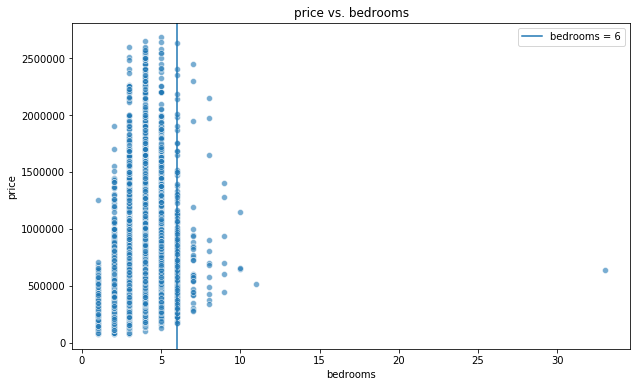

In [1946]:
# let's check 'bedrooms'
# scatterplot of price vs. bedrooms.

df_plot2=df[['price','bedrooms']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='bedrooms', y='price',data=df_plot2,alpha=0.6)
plt.axvline(x=6, label=('bedrooms = 6'))
# plt.axhline(y=3600000, label=('price = $3.6 million'),color = 'r')
plt.title('price vs. bedrooms')
plt.legend()
plt.show();

In [1947]:
# Let's get rid of the single outlier with more than 30 bedrooms (!).
df = df.loc[df['bedrooms']< 30]

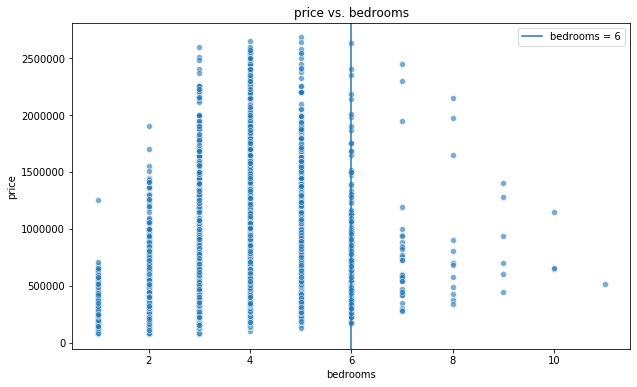

In [1948]:
#Checking. Repeating the same plot from updated df
#scatterplot of price vs. bedrooms.

df_plot2=df[['price','bedrooms']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='bedrooms', y='price',data=df_plot2,alpha=0.6)
plt.axvline(x=6, label=('bedrooms = 6'))
# plt.axhline(y=3600000, label=('price = $3.6 million'),color = 'r')
plt.title('price vs. bedrooms')
plt.legend()
plt.show();

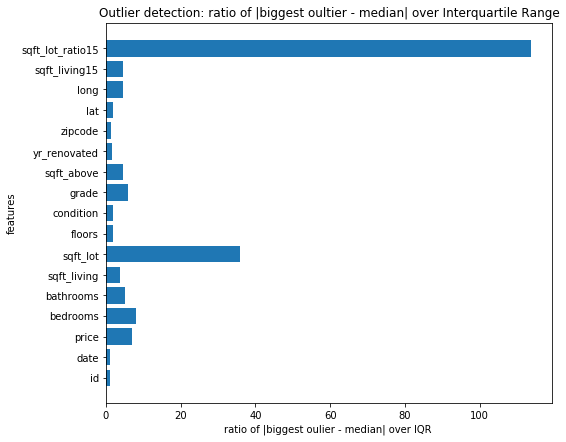

In [1949]:
# Let's look at the same bar plot as before to detect ouliers using our latest updated data
# detect ouliers using InterQuartile Range (IQR) 
dico={}
for col in df.columns:
    if df[col].quantile(.75) - df[col].quantile(.25)  != 0:
#         For features with IQR > 0, calculate the distance of the biggest outlier to the median 
        maxi=max(df[col].max() - df[col].median() ,  df[col].median() -df[col].min() )
#     divide by IQR 
        dico[col] = maxi  /  (df[col].quantile(.75) - df[col].quantile(.25))
# visualization of the ratio with a bar plot
plt.figure(figsize = (8,7))
plt.barh( list(dico.keys()) ,list(dico.values())  )
plt.xlabel('ratio of |biggest oulier - median| over IQR ')
plt.ylabel('features')
plt.title('Outlier detection: ratio of |biggest oultier - median| over Interquartile Range')
plt.show();

## 1. Looking for non-numerical data - done
## 2. Detect and Address Outliers - done
## 3. Collinearity between features and correlation to target

In [1950]:
# correlation between each column of df. 
# absolute value as we are only interested in the strength of the correlation, not the sign.
correl = np.abs(df.corr())
# Let's keep only correlation above 3%
correl_filt=correl > .03


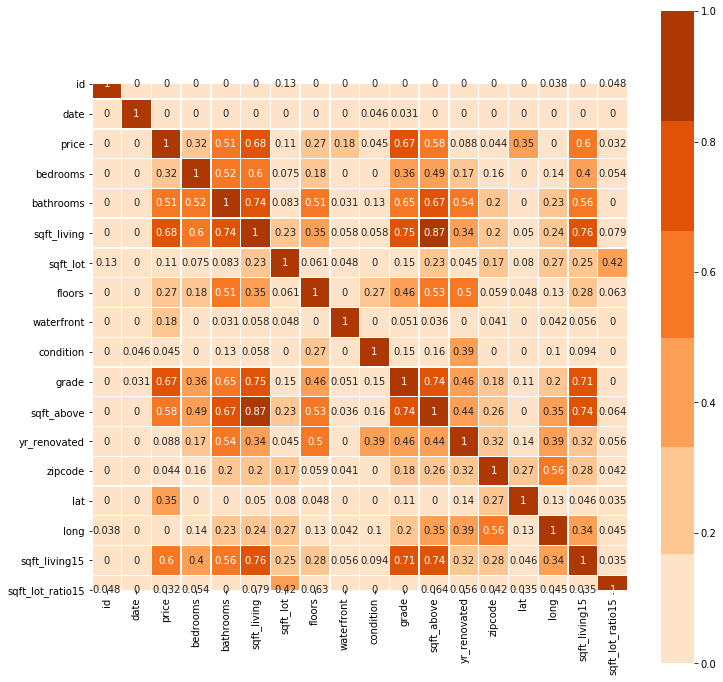

In [1951]:
plt.figure(figsize=(12,12))
sns.heatmap(data=correl_filt*correl,cmap = sns.color_palette('Oranges'),annot = True,
#              fmt="f",
            cbar=True, center=.5,
            square = True, vmin=0, vmax=1,
           linewidths=.4,linecolor='white');

## Conclusion:
#### Decent predictors uncorrelated with any other:                     waterfront, lat, sqft_lot
#### Good predictors mildly correlated with others:                   yr_renovated, floors, sqft_basement, bedrooms, bathrooms 
#### Very Good predictors highly correlated with each other:   sqft_above, sqft_living,15, grade, sqft_living

#### For now we will keep only these predictors and the target

In [1952]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot_ratio15'],
      dtype='object')

In [1953]:
df = df.drop(['id', 'date','condition', 'zipcode', 'long','sqft_lot_ratio15'], axis = 1)

In [1954]:
# check:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'grade', 'sqft_above', 'yr_renovated', 'lat',
       'sqft_living15'],
      dtype='object')

## 1. Looking for non-numerical data - done
## 2. Detect and Address Outliers - done
## 3. Collinearity between features and correlation to target  - done
## 4. Additional Feature Selection. Addressing multicollinearity between sqft_above, sqft_living,15, grade and sqft_living

### Rationale for sqft_living15:

#### For sqft_living15, we proceed the same as for sqft_lot15. We are interested in the ratio between sqft_living and sqft_living15 and how it compares to 1. This enables to estimate if the house is bigger or smaller than the neighbors and it should influence the price.


In [1955]:
# To avoid collinearity problems, we will replace sqft_living15 by a ratio between sqft_living and sqft_living15.
df['sqft_living15'] = df['sqft_living']/df['sqft_living15']

In [1956]:
# rename column
df.rename(columns={'sqft_living15': 'sqft_living_ratio15'},inplace = True)

In [1957]:
# check
df['sqft_living_ratio15'].describe()

count    21187.000000
mean         1.047048
std          0.307769
min          0.187279
25%          0.880240
50%          1.000000
75%          1.154271
max          6.000000
Name: sqft_living_ratio15, dtype: float64

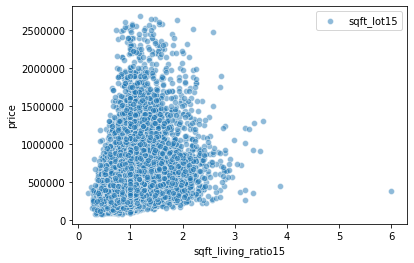

In [1958]:
# check:
sns.scatterplot(x='sqft_living_ratio15', y='price',data=df,alpha=0.5,label = feat)

In [1959]:
# remove outlier 
df = df.loc[df['sqft_living_ratio15']< 5]

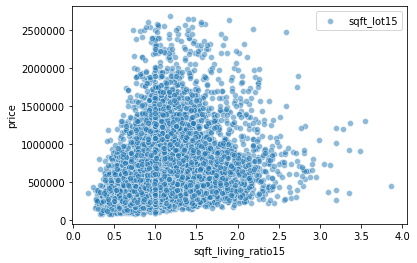

In [1960]:
# check:
sns.scatterplot(x='sqft_living_ratio15', y='price',data=df,alpha=0.5,label = feat)

In [1961]:
# compute correlation of new variable with price
dftemp2=df[['sqft_living','price','sqft_living_ratio15']]
dftemp2.corr()

,sqft_living,price,sqft_living_ratio15
sqft_living,1.000000,0.679641,0.551255
price,0.679641,1.000000,0.264950
sqft_living_ratio15,0.551255,0.264950,1.000000


### Conclusion:
#### We created a new variable sqft_living_ratio15,which has a good correlation with the target price (~26%)
#### It is correlated with sqft_living, but it brings additional information about the neighborhood that are likely to influence the price. So, we will keep this new feature

### Rationale for  sqft_living, sqft_above and grade  

#### We chose to combine  sqft_living and  grade by multiplying them together and creating a new feature a new feature that will replace sqft_living and  grade

#### Additionally we will keep sqft_above as it gives information that is not embedded in sqft_living and has a strong correlation with the target.

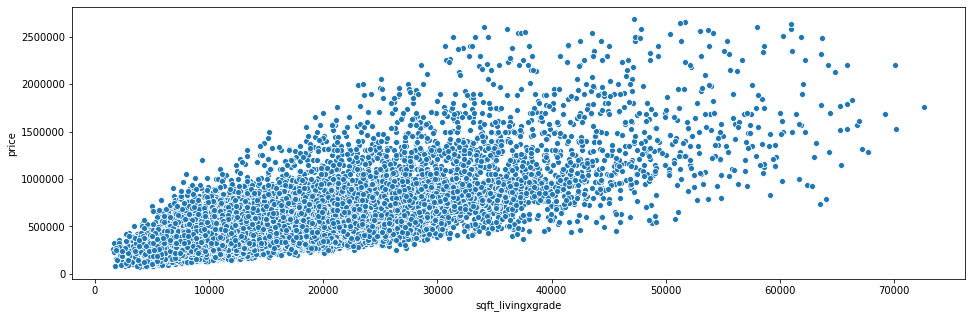

In [1962]:

# new feature 
df['sqft_livingxgrade'] = df['sqft_living']*df['grade']

# remove 'sqft_living' and 'grade' 
df.drop(['sqft_living','grade'],axis = 1,inplace = True)

# visualization: scatterplot price vs new feature
plt.figure(figsize=(16,5))
sns.scatterplot( x=df['sqft_livingxgrade'], y=df['price'])
plt.show();




In [1963]:
# check
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront',
       'sqft_above', 'yr_renovated', 'lat', 'sqft_living_ratio15',
       'sqft_livingxgrade'],
      dtype='object')

# 1. Looking for non-numerical data - done
# 2. Detect and Address Outliers - done¶
# 3. Collinearity between features and correlation to target - done
# 4. Additional Feature Selection. Addressing multicollinearity between sqft_above, sqft_living,15, grade and sqft_living   - done
# 5. Address categorical variables


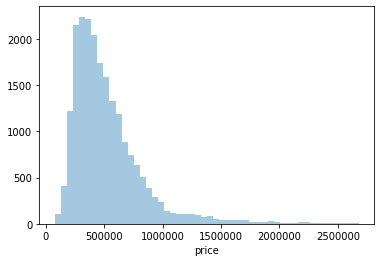

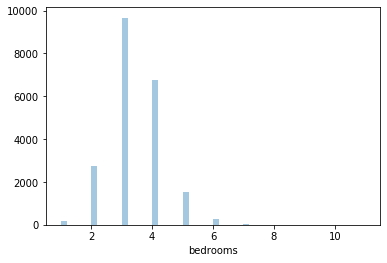

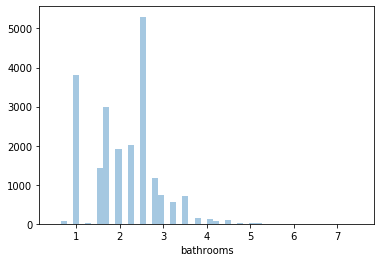

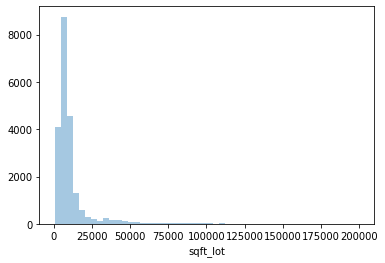

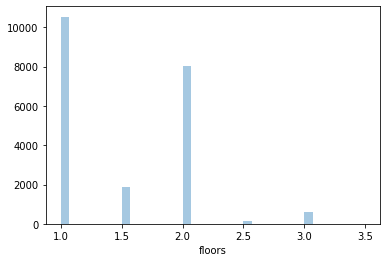

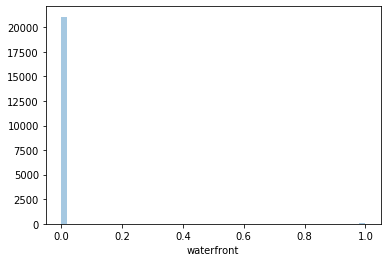

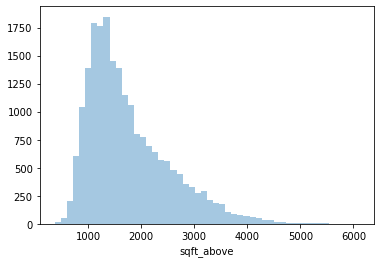

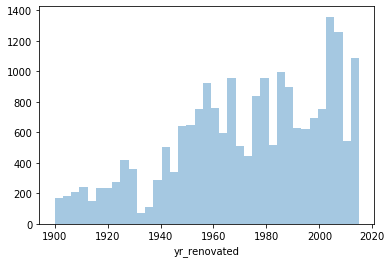

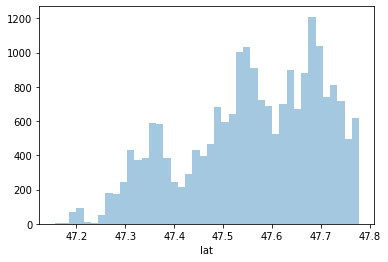

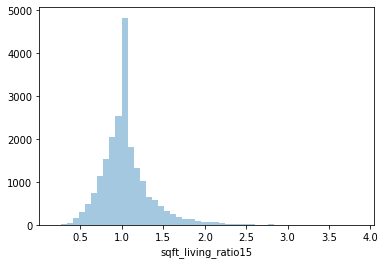

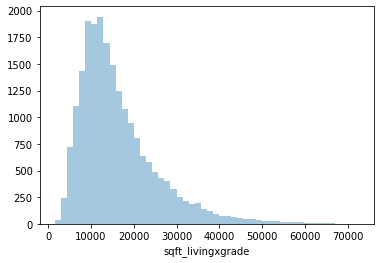

In [1964]:
# Violin plots to detect categorical variables
for feat in df.columns:
    sns.distplot(df[feat],kde=False)
    plt.show()

### Discrete variables are:
### bedrooms, bathrooms, floors and waterfront

In [1965]:
print(df['bedrooms'].unique())
bedroom_dummies= pd.get_dummies(df.bedrooms,prefix='bed',drop_first=True)
print(df['bathrooms'].unique())
bathrooms_dummies= pd.get_dummies(df.bathrooms,prefix='bath',drop_first=True)
print(df['floors'].unique())
floors_dummies= pd.get_dummies(df.floors,prefix='floor',drop_first=True)
print(df['waterfront'].unique())
waterf_dummies= pd.get_dummies(df.waterfront,prefix='waterf',drop_first=True)

[ 3  2  4  5  1  6  7  8  9 11 10]
[1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 4.25 3.75 1.25 5.   0.5  5.25 6.   7.5  5.5  5.75]
[1.  2.  1.5 3.  2.5 3.5]
[0. 1.]


In [1966]:
print(bedroom_dummies.head())
print(bathrooms_dummies.head())
print(floors_dummies.head())
print(waterf_dummies.head())

   bed_2  bed_3  bed_4  bed_5  bed_6  bed_7  bed_8  bed_9  bed_10  bed_11
0      0      1      0      0      0      0      0      0       0       0
1      0      1      0      0      0      0      0      0       0       0
2      1      0      0      0      0      0      0      0       0       0
3      0      0      1      0      0      0      0      0       0       0
4      0      1      0      0      0      0      0      0       0       0
   bath_0.75  bath_1.0  bath_1.25  bath_1.5  bath_1.75  bath_2.0  bath_2.25  \
0          0         1          0         0          0         0          0   
1          0         0          0         0          0         0          1   
2          0         1          0         0          0         0          0   
3          0         0          0         0          0         0          0   
4          0         0          0         0          0         1          0   

   bath_2.5  bath_2.75  bath_3.0  ...  bath_4.0  bath_4.25  bath_4.5  \
0        

In [1967]:
df = df.drop(['bedrooms','bathrooms','floors', 'waterfront'],axis =1) 
df= pd.concat([df, bedroom_dummies,bathrooms_dummies,floors_dummies,waterf_dummies], axis=1)

In [1968]:
# checking df
df.head()

,price,sqft_lot,sqft_above,yr_renovated,lat,sqft_living_ratio15,sqft_livingxgrade,bed_2,bed_3,bed_4,...,bath_5.5,bath_5.75,bath_6.0,bath_7.5,floor_1.5,floor_2.0,floor_2.5,floor_3.0,floor_3.5,waterf_1.0
0,221900.0,5650,1180,1955.0,47.5112,0.880597,8260,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,7242,2170,1991.0,47.7210,1.520710,17990,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,180000.0,10000,770,1933.0,47.7379,0.283088,4620,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,5000,1050,1965.0,47.5208,1.441176,13720,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,8080,1680,1987.0,47.6168,0.933333,13440,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# 1. Looking for non-numerical data - done¶
# 2. Detect and Address Outliers - done¶
# 3. Collinearity between features and correlation to target - done
# 4. Additional Feature Selection. Addressing multicollinearity between sqft_above, sqft_living,15, grade and sqft_living - done
# 5. Address categorical variables - done
# 6. Features' normalization and standardization

count    2.118600e+04
mean     5.263721e+05
std      3.132509e+05
min      7.800000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.371875e+05
max      2.680000e+06
Name: price, dtype: float64


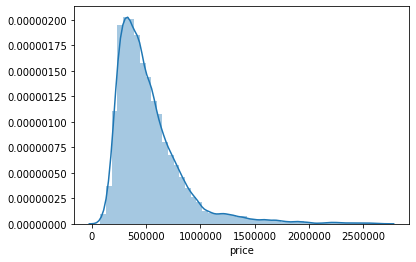

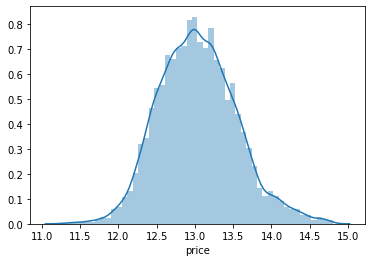

In [1969]:
# 'price' normalization
print(df['price'].describe())
sns.distplot(df['price'])
plt.show();
sns.distplot(np.log(df['price']))
plt.show();

# real change in df:
df['price'] = np.log(df['price'])


count    21186.000000
mean     16383.537902
std       9265.523432
min       1560.000000
25%      10010.000000
50%      14040.000000
75%      20320.000000
max      72660.000000
Name: sqft_livingxgrade, dtype: float64


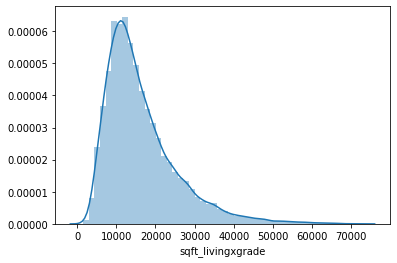

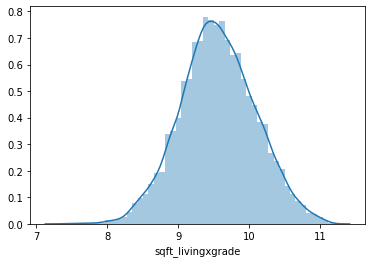

In [1970]:
# 'sqft_livingxgrade' normalization
print(df['sqft_livingxgrade'].describe())
sns.distplot(df['sqft_livingxgrade'])
plt.show();
sns.distplot(np.log(df['sqft_livingxgrade']))
plt.show();

# real change in df:
df['sqft_livingxgrade'] = np.log(df['sqft_livingxgrade'])

count    21186.000000
mean      1763.231474
std        785.533642
min        370.000000
25%       1190.000000
50%       1550.000000
75%       2180.000000
max       6110.000000
Name: sqft_above, dtype: float64


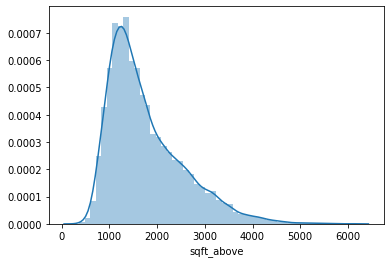

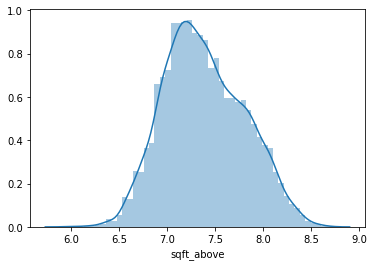

In [1971]:
# 'sqft_above' normalization
print(df['sqft_above'].describe())
sns.distplot(df['sqft_above'])
plt.show();
sns.distplot(np.log(df['sqft_above']))
plt.show();

# real change in df:
df['sqft_above'] = np.log(df['sqft_above'])

# 7.  Train - Test Split  

In [1972]:
# Train - Test Split of the data points
X= df.drop(['price'],axis=1)
y=df['price']

linreg = LinearRegression()
# Split the data randomly into training and test sets. 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

# check sizes
print( [ t.shape[:] for t in [X_train,X_test,y_train,y_test]])
print( X_test.shape[0]/( X_train.shape[0]+X_test.shape[0] ) )

[(16948, 45), (4238, 45), (16948,), (4238,)]
0.20003776078542435


## Multiple linear regression

In [1973]:

X_train_int = sm.add_constant(X_train)  # contains all predictors and a constant column =1 for intercept
model = sm.OLS(y_train,X_train_int).fit() # y_train is a one column dataframe containing the dependent variable
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     1027.
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:41:50   Log-Likelihood:                -1604.0
No. Observations:               16948   AIC:                             3298.
Df Residuals:                   16903   BIC:                             3646.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -53.3673      0.810    -65.872      0.000     -54.955     -51.779
sqft_lot            -2.452e-08   1.34e-07     -0.183      0.855   -2.87e-07    2.38e-07
sqft_above             -0.0792      0.012     -6.570      0.000      -0.103      -0.056
yr_renovated           -0.0033      0.000    -32.085      0.000      -0.004      -0.003
lat                     1.3808      0.016     87.884      0.000       1.350       1.412
sqft_living_ratio15    -0.2451      0.008    -29.448      0.000      -0.261      -0.229
sqft_livingxgrade       0.8246      0.010     78.641      0.000       0.804       0.845
bed_2                  -0.0779      0.023     -3.387      0.001      -0.123      -0.033
bed_3                  -0.1729      0.023     -7.500      0.000      -0.218      -0.128
bed_4                  -0.2121      0.024     -8.964      0.000      -0.258      -0.166
bed_5                  -0.2421      0.025     -9.729      0.000      -0.291      -0.193
bed_6                  -0.2890      0.030     -9.569      0.000      -0.348      -0.230
bed_7                  -0.2576      0.060     -4.293      0.000      -0.375      -0.140
bed_8                  -0.2460      0.093     -2.659      0.008      -0.427      -0.065
bed_9                  -0.3112      0.123     -2.531      0.011      -0.552      -0.070
bed_10                 -0.2181      0.159     -1.368      0.171      -0.531       0.095
bed_11                 -0.0718      0.268     -0.268      0.789      -0.597       0.453
bath_0.75               0.4363      0.138      3.172      0.002       0.167       0.706
bath_1.0                0.3185      0.133      2.388      0.017       0.057       0.580
bath_1.25               0.4372      0.172      2.540      0.011       0.100       0.775
bath_1.5                0.3080      0.134      2.306      0.021       0.046       0.570
bath_1.75               0.3270      0.133      2.449      0.014       0.065       0.589
bath_2.0                0.3546      0.134      2.655      0.008       0.093       0.616
bath_2.25               0.3338      0.134      2.498      0.012       0.072       0.596
bath_2.5                0.3386      0.134      2.535      0.011       0.077       0.600
bath_2.75               0.3879      0.134      2.899      0.004       0.126       0.650
bath_3.0                0.4125      0.134      3.078      0.002       0.150       0.675
bath_3.25               0.4809      0.134      3.582      0.000       0.218       0.744
bath_3.5                0.4984      0.134      3.714      0.000       0.235       0.761
bath_3.75               0.5950      0.136      4.374      0.000       0.328       0.862
bath_4.0                0.5494      0.137      4.020      0.000       0.282       0.817
bath_4.25               0.6645      0.139      4.775      0.000       0.392       0.937
bat

## QC 


## Interpretation of statsmodel diagnostics:
### 1. R-squared adjusted = 73%. IT means that 73% of the variations of the target variable price are predicted by the model.
### 2. JB test value is  high (507) and the p-value is extremely close to zero. The Null hypothesis for the JB test is that the residuals are normally distributed. This hypothesis should be rejected. One of the assumptions  for linear regression is not true !

In [1974]:
# prediction for test  and training set:
X_test_int = sm.add_constant(X_test) # adds a constant column =1 for intercept (similar to X_train_int)
y_hat_test = model.predict(X_test_int)
y_hat_train = model.predict(X_train_int)

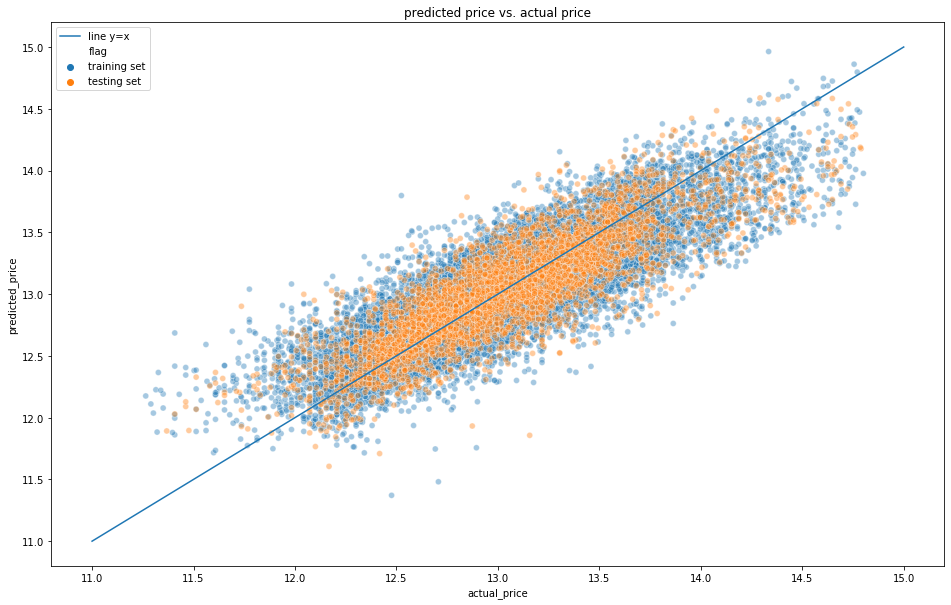

In [2017]:
# visualization of residuals

# conversion of results for training set into a dataframe
y_train_df = pd.DataFrame(y_train)
y_hat_train_df = pd.DataFrame(y_hat_train)
y_train_df=pd.concat([y_train_df,y_hat_train_df],axis=1)
y_train_df.columns = ['actual_price','predicted_price']
y_train_df['flag']='training set'

# conversion of results for test set into a dataframe
y_test_df = pd.DataFrame(y_test)
y_hat_test_df = pd.DataFrame(y_hat_test)
y_test_df=pd.concat([y_test_df,y_hat_test_df],axis=1)
y_test_df.columns = ['actual_price','predicted_price']
y_test_df['flag']='testing set'

# putting together the training and test sets
y_plot = pd.concat ([y_train_df,y_test_df],axis = 0)

# scatter plot of training and test sets' predictions vs. actuals + line y=x for reference
plt.figure(figsize=(16,10))
sns.scatterplot(x='actual_price', y='predicted_price',hue ='flag',data=y_plot , alpha=.4)
plt.plot([11,15],[11,15], label = 'line y=x')
plt.title('predicted price vs. actual price')
plt.legend()
plt.show();

In [1976]:
res_test=y_hat_test-y_test
res_train=y_hat_train-y_train

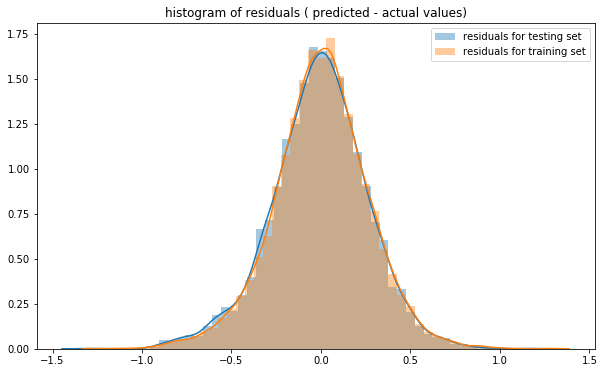

In [2018]:
plt.figure(figsize=(10,6))
sns.distplot( res_test , label = 'residuals for testing set')
sns.distplot( res_train , label = 'residuals for training set')
plt.title('histogram of residuals ( predicted - actual values)')
plt.legend()
plt.show();

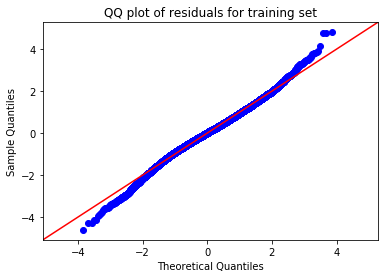

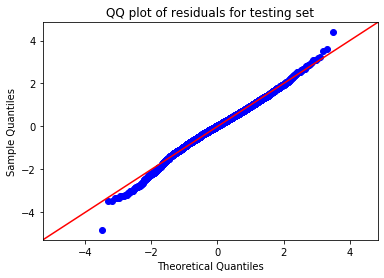

In [2004]:
# QC Normality of residuals
fig = sm.graphics.qqplot(res_train, dist=stats.norm, line='45', fit=True)
plt.title('QQ plot of residuals for training set')
fig = sm.graphics.qqplot(res_test, dist=stats.norm, line='45', fit=True)
plt.title('QQ plot of residuals for testing set');


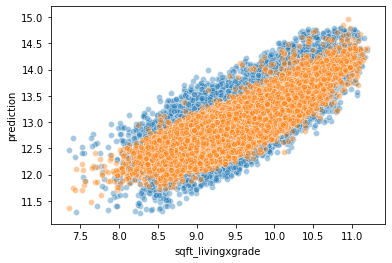

In [2031]:
# QC Heteroscedasticity
# scatterplot of residuals vs feature(s)
# res_train
# res_test
# X['sqft_livingxgrade']
# t=pd.concat([res_train,res_test])
# t
# X['sqft_livingxgrade']

sns.scatterplot(x='sqft_livingxgrade', y='price',data=df , alpha=.4)

# prediction for X:
X_int = sm.add_constant(X) # adds a constant column =1 for intercept (similar to X_train_int)
y_hat = model.predict(X_int)

dfprediction=pd.concat([X_int,y_hat],axis = 1)
dfprediction.rename(columns={0:'prediction'},inplace=True)
dfprediction.columns
sns.scatterplot(x='sqft_livingxgrade', y='prediction',data=dfprediction , alpha=.4)

# graph: residuals vs predicted value

In [1996]:

# Calculate mean square errors
train_mse = mean_squared_error(y_train,y_hat_train)
test_mse = mean_squared_error(y_test,y_hat_test) 
print ('Mean Squared Error for training set : ',train_mse)
print ('Mean Squared Error for testing set : ',test_mse)
print ('difference (in %):  ', 100*(abs(train_mse-test_mse)) / train_mse)

Mean Squared Error for training set :  0.0707509030259549
Mean Squared Error for testing set :  0.07191881455161062
difference (in %):   1.6507372707699206
